In [1]:
%cd ../../

/mnt/c/Users/aryam/Documents/school/year2/spring/DSC291 - Large Scale Statistical Analysis/project/species-gene-coexp


In [25]:
expr = "data/data.tsv"
annot = "data/gene_annotations.tsv.gz"
aucs = "data/aucs.tsv.gz"

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

In [4]:
tpm = pd.read_csv(expr, sep="\t", header=0, index_col=list(range(3)))
tpm.head()

Mouse_gene_TPM  Human_gene_TPM  \
Subclass Gene   Transcript                                           
Astro    TSPAN6 ENST00000373020.8            45.27           86.94   
         DPM1   ENST00000371582.8           213.19           88.54   
                ENST00000371588.9           213.19           88.54   
         FUCA2  ENST00000002165.10          142.11           26.09   
         GCLC   ENST00000509541.5            28.15           36.55   

                                    Mouse_Isoform_Proportion  \
Subclass Gene   Transcript                                     
Astro    TSPAN6 ENST00000373020.8                   0.972830   
         DPM1   ENST00000371582.8                   0.294479   
                ENST00000371588.9                   0.670435   
         FUCA2  ENST00000002165.10                  0.987123   
         GCLC   ENST00000509541.5                   0.003552   

                                    Human_Isoform_Proportion  
Subclass Gene   Transcript                                    
Astro    TSPAN6 ENST00000373020.8                   0.994364  
         DPM1   ENST00000371582.8                   0.075446  
                ENST00000371588.9                   0.762932  
         FUCA2  ENST00000002165.10                  0.992718  
         GCLC   ENST00000509541.5                   0.793160

In [5]:
# just get the first transcript in each gene
tpm = tpm.groupby(['Subclass', 'Gene']).first()
tpm.head()

Mouse_gene_TPM  Human_gene_TPM  Mouse_Isoform_Proportion  \
Subclass Gene                                                               
Astro    AAAS             16.24          121.01                  0.880542   
         AACS             36.53           19.05                  0.310430   
         AAMDC            40.93           50.30                  0.968238   
         AAMP             40.81           26.85                  0.628522   
         AARSD1           37.88           56.02                  0.260032   

                 Human_Isoform_Proportion  
Subclass Gene                              
Astro    AAAS                    0.184695  
         AACS                    0.940157  
         AAMDC                   0.752883  
         AAMP                    0.831657  
         AARSD1                  0.503570

In [7]:
# rename the columns
tpm.columns = ['mouse_tpm', 'human_tpm', 'mouse_isoform', 'human_isoform']
tpm.head()

mouse_tpm  human_tpm  mouse_isoform  human_isoform
Subclass Gene                                                      
Astro    AAAS        16.24     121.01       0.880542       0.184695
         AACS        36.53      19.05       0.310430       0.940157
         AAMDC       40.93      50.30       0.968238       0.752883
         AAMP        40.81      26.85       0.628522       0.831657
         AARSD1      37.88      56.02       0.260032       0.503570

In [60]:
# take the log of the TPM values
for col in ['mouse_tpm', 'human_tpm']:
    tpm[col] = tpm[col].apply(np.log)
tpm.head()

mouse_tpm  human_tpm  mouse_isoform  human_isoform
Subclass Gene                                                      
Astro    AAAS     2.787477   4.795873       0.880542       0.184695
         AACS     3.598134   2.947067       0.310430       0.940157
         AAMDC    3.711863   3.918005       0.968238       0.752883
         AAMP     3.708927   3.290266       0.628522       0.831657
         AARSD1   3.634423   4.025709       0.260032       0.503570

In [61]:
aurocs = pd.read_csv(aucs, sep="\t", index_col=0).mean(axis=1)
aurocs.rename('auroc', inplace=True)

Gene
AAMP        0.627040
AARSD1      0.528011
AASDHPPT    0.384777
ABCC5       0.430580
ABCE1       0.581894
              ...   
ZNF800      0.501491
ZNF830      0.545017
ZNHIT1      0.407573
ZRANB2      0.655198
ZRSR2       0.509334
Name: auroc, Length: 1970, dtype: float64

In [93]:
tpm_diff = (tpm['mouse_tpm'] - tpm['human_tpm']).groupby('Gene').max()
isoform_diff = (tpm['mouse_isoform'] - tpm['human_isoform']).groupby('Gene').max()

In [95]:
df = pd.merge(aurocs, pd.DataFrame({'tpm': tpm_diff, 'isoform': isoform_diff}), left_index=True, right_index=True)
df

,auroc,tpm,isoform
Gene,,,
AAMP,0.627040,1.820003,0.350159
AARSD1,0.528011,1.583174,0.271493
AASDHPPT,0.384777,1.000962,-0.510015
ABCC5,0.430580,1.086551,0.592780
ABCE1,0.581894,0.903617,-0.172495
...,...,...,...
ZNF800,0.501491,2.120354,0.528694
ZNF830,0.545017,2.423134,0.255045
ZNHIT1,0.407573,1.320639,0.000000


In [96]:
genes = pd.read_csv(annot, sep="\t", header=0, index_col=1, usecols=list(range(1, 4)))
genes.index.name = "Gene"
genes

,gene_type,level
Gene,,
DDX11L1,transcribed_unprocessed_pseudogene,2
WASH7P,unprocessed_pseudogene,2
MIR6859-1,miRNA,3
MIR1302-2HG,lncRNA,2
MIR1302-2,miRNA,3
...,...,...
MT-ND6,protein_coding,3
MT-TE,Mt_tRNA,3
MT-CYB,protein_coding,3


In [97]:
df = df.join(genes, how='inner')
df

,auroc,tpm,isoform,gene_type,level
Gene,,,,,
AAMP,0.627040,1.820003,0.350159,protein_coding,1
AARSD1,0.528011,1.583174,0.271493,protein_coding,2
AASDHPPT,0.384777,1.000962,-0.510015,protein_coding,2
ABCC5,0.430580,1.086551,0.592780,protein_coding,1
ABCE1,0.581894,0.903617,-0.172495,protein_coding,2
...,...,...,...,...,...
ZNF800,0.501491,2.120354,0.528694,protein_coding,2
ZNF830,0.545017,2.423134,0.255045,protein_coding,2
ZNHIT1,0.407573,1.320639,0.000000,protein_coding,2


In [103]:
model = smf.ols(formula="auroc ~ tpm + isoform + C(gene_type) + level", data=df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  auroc   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     8.747
Date:                Mon, 02 May 2022   Prob (F-statistic):           1.29e-10
Time:                        21:18:59   Log-Likelihood:                 1458.6
No. Observations:                1927   AIC:                            -2901.
Df Residuals:                    1919   BIC:                            -2857.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.6131      0.082      7.458      0.000       0.452       0.774
C(gene_type)[T.lncRNA]            -0.0176      0.092     -0.192      0.848      -0.197       0.162
C(gene_type)[T.miRNA]              0.1354      0.115      1.181      0.238      -0.089       0.360
C(gene_type)[T.misc_RNA]          -0.0476      0.140     -0.341      0.733      -0.321       0.226
C(gene_type)[T.protein_coding]     0.0190      0.081      0.234      0.815      -0.141       0.179
tpm                               -0.0169      0.003     -5.711      0.000      -0.023      -0.011
isoform                           -0.0396      0.008     -4.865      0.000      -0.056      -0.024
level                             -0.0111      0.005     -2.082      0.037      -0.021      -0.001
==============================================================================
Omnibus:                        6.737   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.335
Skew:                           0.102   Prob(JB):                       0.0421
Kurtosis:                       2.808   Cond. No.                         187.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
sumstats = res.summary2().tables[1]
sumstats.to_csv('data/reg_res.tsv', sep="\t")

Text(0, 0.5, 'Mean AUROC')

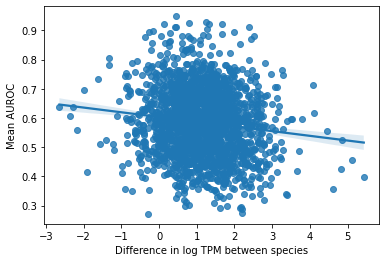

In [104]:
tpm_fig = sns.regplot(x="tpm", y="auroc", data=df)
tpm_fig.set_xlabel('Difference in log TPM between species')
tpm_fig.set_ylabel('Mean AUROC')

Text(0, 0.5, 'Mean AUROC')

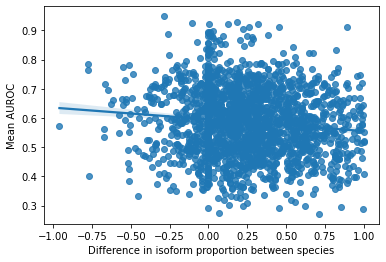

In [107]:
isoform_fig = sns.regplot(x="isoform", y="auroc", data=df)
isoform_fig.set_xlabel('Difference in isoform proportion between species')
isoform_fig.set_ylabel('Mean AUROC')